# Assignment 1

### EECS 491
### Tristan Maidment - TDM47

#### Goal

My goal for this assignment is to use Bayes' Rule to be able to classify the loss condition for packets retransmitted by the TCP protocol.

Traditionally, TCP has two conditions for re-transmitting packets.  TCP protocol classifies the lack of an acknowledgement after a certain time as a "timeout".  Upon receiving three acknowledgements for the same packet in a row, the packet is "fast-retransmited", or instantly sent.  Both of these events are related to a continuous variable, RTT that defines the time taken for a packet to be sent to a receiver, and an acknowledgement made.  Since both methods require a form of induciton for packet retransmission, (when it is most probable that a packet should be re-sent,) they have natural variance.  However, I should be able to predict the retransmission method for a given packet is lost, given RTT data of timeout and fast-retransmit events.

#### Method

To classify re-transmitted packets I will use the following adaptation of Bayes' Rule:

`P(timeout|RTT) = P(RTT|timeout)P(timeout)`

The fast-retransmit and timeout events are mutually exclusive - only one event may occur per packet.  Due to this, I am able to conclude: 

`P(fast-retransmit|RTT) = 1 - P(timeout|RTT)`

Alternatively, I can calculate `P(fast-retransmit|RTT)` via it's own distribution, and normalize the two.

I will use the RTT data of timeout and fast-retransmit events to create two likelihood distributions for both variables.

I will be looking to determine the possible "hidden variable" linking the fast-retransmit and timeout events to a packet retransmission event.



#### Code

First, I import the dependencies used for this assignment.

Please note that I have not used Python before, and a fair amount of this code is modifications of example code.


In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
%matplotlib inline

To acquire data for this assignment, I captured the network traffic from my laptop using the program WireShark.

Due to limitations in my ability to decipher *.pcap* files and find packet RTT, I used a trick learned in EECS 325 Computer Networks I - count the number of hops the packet took from source to destination.  Since the source packet defines the TTL, I only observed packets with TTLs lower than the default value of 64, in order to prevent problems with packets that have higher TTLs set.

I define three lists to hold the TTLs for each respective event.

In [3]:
hops = []
hops_retrans = []
hops_timeout = []

To get TTL data, I had to create a custom dataset using the Wireshark output.  It required me to format the TTLs and packet information into a CSV file, which I parsed for information.

I classified each packet using the packet information that WireShark provides.  I did this by reading through the output to find how the retransmission events were classified.

*Note that it took me multiple attempts (with 100000+ packets each time) to acquire data with enough fast-retransmisison events.*

In [4]:
with open('TTL3.csv', newline='') as csvfile:
    ttls = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in ttls:
        if row[1]:
            ttl = 64 - int(row[1])
            #I removed all TTL that are below 0.  
            #These TTL are either set at a value higher than 64 by the sender,
            #or packets being sent to local devices on my home network. (TTL = 0)
            if ttl > 0:
                if "[TCP Retransmission]" in row[2]:
                    hops_timeout.append(ttl)
                elif "[TCP Fast Retransmission]" in row[2]:
                    hops_retrans.append(ttl)
                else:
                    hops.append(ttl)

To see the percentage of packets that were retransmitted, I counted the number of packets classified for each event, and printed out the statistics for each event.  Unfortunately the amount of retransmitted packets is very small, but it will have to do.

In [5]:
pkt_total = len(hops) + len(hops_timeout) + len(hops_retrans)
pkt_succ = len(hops)
pkt_time = len(hops_timeout)
pkt_fast = len(hops_retrans)
print("Packets successful", pkt_succ)
print("Packets timed out", pkt_time)
print("Packets fast-retransmitted", pkt_fast)
print("Percent timed out", pkt_time/pkt_total)
print("Percent fast_retransmitted", pkt_fast/pkt_total)
print("Packets total", pkt_total)

Packets successful 104546
Packets timed out 73
Packets fast-retransmitted 43
Percent timed out 0.0006974833272821081
Percent fast_retransmitted 0.0004108463434675431
Packets total 104662


I created a plot for the retransmission events and packets that were properly acknowledged.

In addition, I calculated the mean, standard deviation, and variance of both events, as I am assuming a normal distribution.

Successfully Transmitted
Mean 10.172871271975973
STD 3.31149695250862
VAR 10.966012066473878


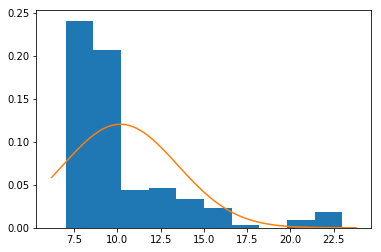

In [6]:
mu, std = stats.norm.fit(hops)
plt.hist(hops, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p)

print("Successfully Transmitted")
print("Mean", np.mean(hops))
print("STD", np.std(hops))
print("VAR", np.std(hops) * np.std(hops))

Timeout
Mean 11.232876712328768
STD 4.5616644040837855
VAR 20.808782135485078


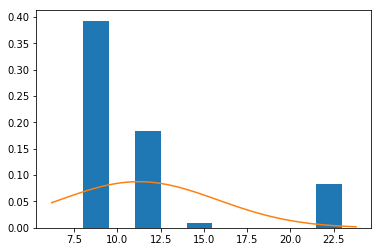

In [7]:
mu, std = stats.norm.fit(hops_timeout)
plt.hist(hops_timeout, normed=True)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p)

print("Timeout")
print("Mean", np.mean(hops_timeout))
print("STD", np.std(hops_timeout))
print("VAR", np.std(hops_timeout) * np.std(hops_timeout))

Fast-Retransmit
Mean 14.511627906976743
STD 1.70324031847447
VAR 2.9010275824770138


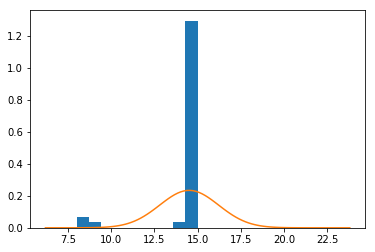

In [8]:
mu, std = stats.norm.fit(hops_retrans)
plt.hist(hops_retrans, normed=True)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p)

print("Fast-Retransmit")
print("Mean", np.mean(hops_retrans))
print("STD", np.std(hops_retrans))
print("VAR", np.std(hops_retrans) * np.std(hops_retrans))

It's very interesting to see the concentration of fast retransmits at 15 hops.  Unfortunately the timeout event distribution is similar to that of the successful packets.

I then define the prior, P(loss).  This is a constant as it is the overall packet loss of the model.

In [9]:
packet_loss = (pkt_time+pkt_fast)/pkt_total

To determine the probability of a specific TTL given a certain retransmission event, I use the PDF from the likelihood distributions.

In [10]:
def likelihood_timeout(TTL):
    mu, std = stats.norm.fit(hops_timeout)
    return stats.norm(mu, std).pdf(TTL)

def likelihood_retransmit(TTL):
    mu, std = stats.norm.fit(hops_retrans)
    return stats.norm(mu, std).pdf(TTL)

To define the posterior, we take the likelihood and multiply it by the prior.

In [11]:
def posterior_timeout(TTL):
    return likelihood_timeout(TTL) * packet_loss

def posterior_retransmit(TTL):
    return likelihood_retransmit(TTL) * packet_loss

To determine the classification boundaries between fast-retransmit and timeout, we must normalize the two posterior distributions.

In [12]:
def normalize(val):
    norm_const = posterior_timeout(val) + posterior_retransmit(val)
    return (posterior_timeout(val) / norm_const), (posterior_retransmit(val) / norm_const)

I then graphed the decision boundary for both events, superimposed on each other.  We can see that around 15 TTLs, Bayes' Inference picks the fast-retransmission event over the timeout event.  The likelihood distribution for the fast-retransmit event supports this.

Bayesian Inference Decision w/ Respect to TTL


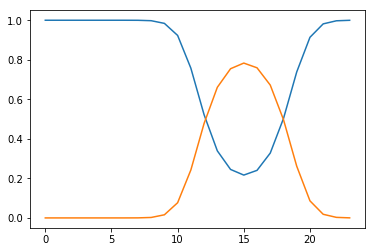

In [13]:
xaxis = []
timeout_prob = []
retransmit_prob = []

for z in range(0, math.ceil(xmax)):
    xaxis.append(z)
    timeout_prob.append(normalize(z)[0])
    retransmit_prob.append(normalize(z)[1])
plt.plot(xaxis, timeout_prob)
plt.plot(xaxis, retransmit_prob)

print("Bayesian Inference Decision w/ Respect to TTL")

### Conclusion

Overall, I believe that I reached my goal in terms of being able to classify what sort of retransmission mechanism a lost packet will take.  Due to limitations in the amount of data I was able to require, I believe that this representation is not accurate of actual TCP throughput, but I believe that it accurately classify's the model I acquired.